<a href="https://colab.research.google.com/github/Shakibap/Data-Science-Portfo/blob/Data-Science/Titanic_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report 

In [62]:
#from google.colab import files
#files.upload()

In [63]:
#files.upload()

In [9]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
valid_data = pd.read_csv('test.csv', index_col='PassengerId')

In [10]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])
valid_data['Title'] = valid_data['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])

In [12]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
 11  Title     891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 90.5+ KB


In [14]:
train_data.shape[0], valid_data.shape[0]

(891, 418)

In [15]:
train_df = train_data[['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Survived']].copy()
valid_df = valid_data[['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']].copy()

In [16]:
train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr,0
2,1,female,38.0,1,0,71.2833,C,Mrs,1
3,3,female,26.0,0,0,7.9250,S,Miss,1
4,1,female,35.0,1,0,53.1000,S,Mrs,1
5,3,male,35.0,0,0,8.0500,S,Mr,0


# **Data Cleaning and Preprocessing**

**finding the outliers**

In [17]:
train_df[(train_df.Sex=='female') & (train_df.Pclass==1)].Survived.sum(), train_df[(train_df.Sex=='female') & (train_df.Pclass==1)].shape[0]

(91, 94)

*It seems most of the class 1 women had been survived so the unsurvived people could be an exceptional*

In [18]:
train_df[(train_df.Sex=='female') & (train_df.Survived==0) & (train_df.Pclass==1)]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
178,1,female,50.0,0,0,28.7125,C,Miss,0
298,1,female,2.0,1,2,151.5500,S,Miss,0
499,1,female,25.0,1,2,151.5500,S,Mrs,0


In [19]:
train_df.drop(index=[178, 298, 499], inplace=True)

**cleaning the columns**

In [20]:
train_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [21]:
valid_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [22]:
Mr_indexes = list(train_df[train_df.Title.isin(['Don', 'Major', 'Sir', 'Capt', 'Jonkheer'])].index)

In [23]:
train_df.loc[Mr_indexes, 'Title'] = 'Mr'

In [24]:
train_df[train_df.Title.isin(['the Countess', 'Lady'])]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
557,1,female,48.0,1,0,39.6,C,Lady,1
760,1,female,33.0,0,0,86.5,S,the Countess,1


In [25]:
train_df.loc[[557, 760], 'Title'] = 'Mrs'

In [26]:
train_df[(train_df.Title =='Dr') & (train_df.Sex=='female')]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
797,1,female,49.0,0,0,25.9292,S,Dr,1


In [27]:
train_df.loc[797, 'Title'] = 'Mrs'

In [28]:
valid_df[valid_df.Title.isin(['Dona'])]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1306,1,female,39.0,0,0,108.9,C,Dona


In [29]:
valid_df.loc[1306, 'Title'] = 'Mrs'

**imputing the missing values**

In [30]:
# Pclass is inherently a categorical feature
train_df.Pclass = train_df.Pclass.astype('object')
valid_df.Pclass = valid_df.Pclass.astype('object')

In [31]:
train_df.isnull().sum(), valid_df.isnull().sum()

(Pclass        0
 Sex           0
 Age         177
 SibSp         0
 Parch         0
 Fare          0
 Embarked      2
 Title         0
 Survived      0
 dtype: int64, Pclass       0
 Sex          0
 Age         86
 SibSp        0
 Parch        0
 Fare         1
 Embarked     0
 Title        0
 dtype: int64)

In [32]:
imputer = SimpleImputer(strategy='most_frequent')
train_df_imputed = train_df.copy()
train_df_imputed.loc[:, 'Embarked'] = imputer.fit_transform(train_df[['Embarked']])

In [33]:
train_df = train_df_imputed

**encoding**

In [34]:
train_df = pd.get_dummies(train_df)
valid_df = pd.get_dummies(valid_df)

**cleaning the columns**

In [35]:
train_df.head()

,Age,SibSp,Parch,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,38.0,1,0,71.2833,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,26.0,0,0,7.9250,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,35.0,1,0,53.1000,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,35.0,0,0,8.0500,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [36]:
train_df['Title_Miss'] = train_df['Title_Miss'] + train_df['Title_Mme'] + train_df['Title_Ms']
train_df['Title_Mrs'] = train_df['Title_Mrs'] + train_df['Title_Mlle']
train_df.drop(columns=['Title_Mme', 'Title_Ms', 'Title_Mlle'], inplace=True)


In [37]:
train_df.head()

,Age,SibSp,Parch,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,38.0,1,0,71.2833,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,26.0,0,0,7.9250,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
4,35.0,1,0,53.1000,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
5,35.0,0,0,8.0500,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0


In [38]:
valid_df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
893,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
894,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
895,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0
896,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0


In [39]:
valid_df['Title_Miss'] = valid_df['Title_Miss'] + valid_df['Title_Ms']
valid_df.drop(columns=['Title_Ms'], inplace=True)

In [40]:
valid_df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0
893,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0
894,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
895,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
896,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0


**imputing the missing values**

In [41]:
train_df.Fare.isnull().sum(), valid_df.Fare.isnull().sum()

(0, 1)

In [42]:
# the mean of Fare is different for each class
train_data.groupby(['Pclass']).Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

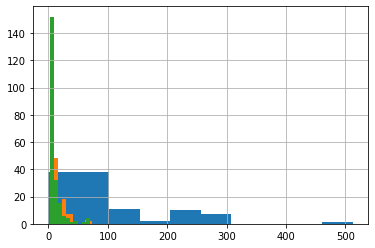

In [43]:
#The distribution of Fare is different for each class
valid_data[valid_data.Pclass==1].Fare.hist()
valid_data[valid_data.Pclass==2].Fare.hist()
valid_data[valid_data.Pclass==3].Fare.hist()

In [44]:
#finding the class of null Fare
valid_df[valid_df.Fare.isnull()]

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,
1044,60.5,0,0,NaN,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0


In [45]:
# the distribution is skewed, so the median is used for imputing the null
valid_df[valid_df.Pclass_3==1].Fare.median()

7.8958

In [46]:
valid_df.loc[1044, 'Fare'] = 7.8958

In [47]:
valid_df.Fare.isnull().sum()

0

In [48]:
train_df.isnull().sum(), valid_df.isnull().sum()

(Age             177
 SibSp             0
 Parch             0
 Fare              0
 Survived          0
 Pclass_1          0
 Pclass_2          0
 Pclass_3          0
 Sex_female        0
 Sex_male          0
 Embarked_C        0
 Embarked_Q        0
 Embarked_S        0
 Title_Col         0
 Title_Dr          0
 Title_Master      0
 Title_Miss        0
 Title_Mr          0
 Title_Mrs         0
 Title_Rev         0
 dtype: int64, Age             86
 SibSp            0
 Parch            0
 Fare             0
 Pclass_1         0
 Pclass_2         0
 Pclass_3         0
 Sex_female       0
 Sex_male         0
 Embarked_C       0
 Embarked_Q       0
 Embarked_S       0
 Title_Col        0
 Title_Dr         0
 Title_Master     0
 Title_Miss       0
 Title_Mr         0
 Title_Mrs        0
 Title_Rev        0
 dtype: int64)

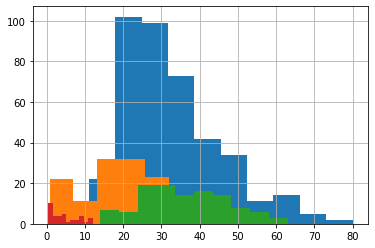

In [49]:
# The distribution of Age is different for groups
train_df[train_df.Title_Mr == 1].Age.hist()
train_df[train_df.Title_Miss == 1].Age.hist()
train_df[train_df.Title_Mrs == 1].Age.hist()
train_df[train_df.Title_Master == 1].Age.hist()

In [50]:
columns_list = ['Title_Master', 'Title_Miss', 'Title_Mr',
                'Title_Mrs', 'Title_Rev', 'Title_Dr', 'Title_Col']

In [51]:
# The distribution of Age is skewed for all of the groups, so the median is used for imputing the nulls
def Age_impute(df):
  imputer = SimpleImputer(strategy='median')
  df_new = pd.DataFrame()
  for c in columns_list:
    df_selected = df[df[c] == 1]
    df_imputed = df_selected.copy()
    df_imputed.loc[:, 'Age'] = imputer.fit_transform(df_selected[['Age']])
    df_new = pd.concat([df_new, df_imputed], axis=0)

  return df_new

In [52]:
train = Age_impute(train_df)
valid = Age_impute(valid_df)

In [53]:
train.isnull().sum().sum(), valid.isnull().sum().sum()

(0, 0)

# **Modeling**

In [54]:
X = train.copy()
y = X.Survived
X.drop('Survived', axis=1, inplace=True)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [56]:
X_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Col', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev'],
      dtype='object')

In [57]:
features = ['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Title_Mr', 'Title_Rev']

In [61]:
model = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3)
x = X[features].copy()
x_train = X_train[features].copy()
x_test = X_test[features].copy()

model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.78      0.89      0.84       133
           1       0.80      0.63      0.70        89

    accuracy                           0.79       222
   macro avg       0.79      0.76      0.77       222
weighted avg       0.79      0.79      0.78       222



In [59]:
x_valid = valid[features].copy()
model.fit(x, y)
predictions = model.predict(x_valid)

*The model tested in Kaggle and the accuracy is 79.425*